# JijModeling+OMMX Adapterを用いた数理モデルの構築とOpenJijでの最適化計算
このチュートリアルでは、JijModelingを用いて数理モデルを定式化し、得られた数理モデルをQUBOに変換し、OpenJijで解くという流れを説明したいと思います。



まず初めに、必要なパッケージをインストールします。
数理モデルを簡単に構築するためのモジュールであるJijModelingとOpenJijの入出力フォーマットと相互に変換するOMMX-OpenJij-Adapterをインストールします。
これらは、`pip`を使ってインストールすることができます。

In [1]:
# !pip install jijmodeling ommx-openjij-adapter

# 巡回セールスマン問題
制約条件付き最適化問題の例として巡回セールスマン問題を解いていきたいと思います。
巡回セールスマン問題は、一人のセールスマンが決められた都市を全て一度づつ訪問し、最終的に元の都市に帰ってくる時に、都市を巡回する最短経路を求めろという問題です。

### 制約条件
この問題では、セールスマンは一つの地点に一度しか訪れることができないという位置に関する制約条件と、セールスマンが一人なのである時刻では一つの都市にしか存在しないという時間に関する制約条件が存在します。

$t$番目に都市$i$を訪れるとき$x_{t,i}=1$、それ以外では$x_{t,i}=0$とするバイナリ変数を用いると、上記の二つの制約条件は、


$$\text{位置に関する制約条件 : }\sum_{t=1}^N x_{t,i}=1 \quad \forall i$$

$$\text{時間に関する制約条件 : }\sum_{i=1}^N x_{t,i}=1 \quad \forall t$$

と書くことができます。

### 目的関数
巡回セールスマン問題は、都市を巡回する最短経路を求めろという問題でした。
そこで、地点$i$と$j$の間の距離を$d_{ij}$とすると、時刻$t$で都市$i$を訪れ、時刻$t+1$で都市$j$を訪れた時の移動距離は、

$$d_{ij}x_{t,i}x_{t+1,j}$$

と書くことができます。
これを合計したもの、

$$\sum_{t=1}^N\sum_{i=1}^N \sum_{j=1}^N d_{ij}x_{t,i}x_{t+1,j}$$

が今回最小化したい目的関数である、合計移動距離になります。

これまでのチュートリアルで述べたようにイジング最適化を行うためには、このような制約条件を持つ数理モデルをIsingハミルトニアンやQUBOハミルトニアンに変換する必要があります。
このような作業を手で行うと面倒ですし、実際に構築した数理モデルとQUBOの間にバグが入り込む可能性があります。
そこで、このような作業を全て自動でおこなってくれるのがJijModelingです。
JijModelingを用いることで、上記のように構築した数理モデルをコーディングし、それを自動的にQUBOに変換してくれます。
ここでは、上記で説明した巡回セールスマン問題を例にとって、JijModelingの使い方について説明していきます。

## JijModelingを用いた巡回セールスマン問題の数理モデルの構築
まず初めに、JijModelingを用いて、問題の数式を記述していきます。
JijModelingでは、通常の数理最適化計算用のモデラーとは異なり、問題インスタンスのデータとは独立に数理モデルを構築していきます。
このように数理モデルを構築することで、数理モデルの汎用性が担保でき、かつ、紙の上で数式を書くように直感的に数式を記述することができます。
さらに、JijModelingで記述された数理モデルは、notebook上ではLaTeXで確認することができます。

ここでは、JijModelingを用いた数理モデルの構築についてひとつづつ見ていきたいと思います。

まずは、問題を記述するための変数と定数を表現しましょう。

In [2]:
import jijmodeling as jm

dist = jm.Placeholder("dist", ndim=2)
N = jm.Placeholder("N")
x = jm.BinaryVar("x", shape=(N, N))
i = jm.Element("i", belong_to=(0,N))
j = jm.Element("j", belong_to=(0,N))
t = jm.Element("t", belong_to=(0,N))

ここで、`jm.Placeholder`は定数を表現しており、ここでは距離行列$d$と都市数$N$を表現するのに用いています。
巡回セールスマン問題においては、この距離行列と都市数によってさまざまな問題が表現されることになります。

バイナリ変数を表現するのが、`jm.BinaryVar`です。
ここでは、$N\times N$のバイナリ変数を定義しています。
次に、総和などで添字の範囲を表現するために`jm.Element`を用いて、`i`,`j`,`t`という添字を定義しています。

JijModelingでは、`jm.Problem`インスタンスを作成し、それに目的関数や制約条件を追加していきます。
では次に、定義した変数を用いて目的関数を定義していきます。

In [3]:
problem = jm.Problem("TSP")
problem += jm.sum([t, i, j], dist[i, j] * x[t, i] * x[(t + 1) % N, j])
problem

総和は`jm.sum`を用いて表現することができます。
`jm.sum`の最初の引数は総和をとる添字で、TSPの目的関数では、3つの添字について総和を取るので、それらの添字(`jm.element`)をリストで渡しています。

次に、制約条件を追加していきます。

In [4]:
# 制約条件1 : 位置に関するonehot制約
problem += jm.Constraint(
            "onehot_location",
            x[:, i].sum() == 1,
            forall=i,
        )

# 制約条件2 : 時間に関するonehot制約
problem += jm.Constraint(
            "onehot_time",
            x[t, :].sum() == 1,
            forall=t,
        )

`jm.Constraint`を用いて制約条件表現することができます。
最初の引数は制約条件の名前、2つ目の引数が制約条件を表現した数式になります。

この制約条件には、オプション引数として、`forall`というものがあります。
これは、数理モデルにおいて、「任意の$i$について」や、「$\forall i$」というように表現されているものをJijModelingで表現するための引数です。

また、制約条件の中に現れている`x[:,i].sum()`という記法は、`jm.sum(t,x[t,i])`という書き方の糖衣構文になっています。

最後に、今記述した数理モデルを確認してみましょう。

In [5]:
problem

説明で用いた数理モデルと同じ数式が表示されていることがわかります。

以上で、数理モデルの構築は終わりです。
このようにJijModelingを用いると、手元の数式と見比べながら数理モデルをコーディングしていくことができます。

## 問題データの作成
問題の数理モデルができたので、次に問題に使うデータを作成します。
ここでは、単純な都市数10で、都市間の距離をランダムにした問題を解いていきます。

(0.0, 1.0)

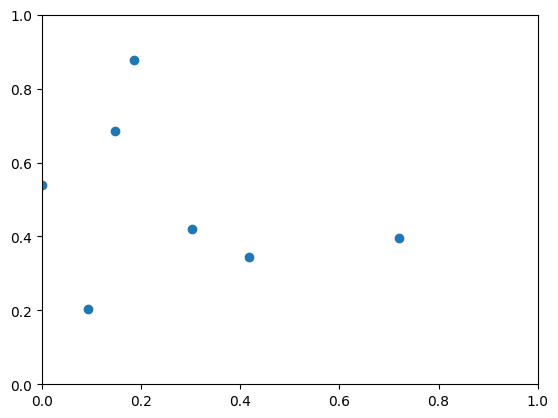

In [6]:
import matplotlib.pyplot as plt
import numpy as np

inst_N = 7
np.random.seed(1)

x_pos = np.random.rand(inst_N)
y_pos = np.random.rand(inst_N)

plt.plot(x_pos, y_pos, 'o')
plt.xlim(0, 1)
plt.ylim(0, 1)

数理モデルを作る際に用いた`jm.Placeholder`にデータを代入するので、Placeholderの名前をkeyに持つ辞書でデータを渡す必要があります。
今回の問題では、`N`と`dist`に値を渡す必要があります。

In [7]:
XX, XX_T = np.meshgrid(x_pos, x_pos)
YY, YY_T = np.meshgrid(y_pos, y_pos)
inst_d = np.sqrt((XX - XX_T)**2 + (YY - YY_T)**2)
instance_data = {"N": inst_N, "dist": inst_d}
instance_data

{'N': 7,
 'dist': array([[0.        , 0.30759475, 0.45952133, 0.13629233, 0.43406434,
         0.35402107, 0.58040301],
        [0.30759475, 0.        , 0.73408488, 0.41859314, 0.64201675,
         0.6567735 , 0.71897319],
        [0.45952133, 0.73408488, 0.        , 0.32503125, 0.20721367,
         0.34684999, 0.38700806],
        [0.13629233, 0.41859314, 0.32503125, 0.        , 0.30817754,
         0.30035264, 0.4733741 ],
        [0.43406434, 0.64201675, 0.20721367, 0.30817754, 0.        ,
         0.48383715, 0.19690151],
        [0.35402107, 0.6567735 , 0.34684999, 0.30035264, 0.48383715,
         0.        , 0.6801809 ],
        [0.58040301, 0.71897319, 0.38700806, 0.4733741 , 0.19690151,
         0.6801809 , 0.        ]])}

## OMMX Instanceへの変換
数理モデルとデータの用意ができたので、次にJijModelingで記述したモデルに先ほどの`instance_data`を代入してOMMX Instanceオブジェクトを作成します。

`OMMX Instance`は数理最適化におけるモデラー<>ソルバー間、モデラー<>モデラー間のデータの受け渡しを行うための共通フォーマットである[OMMX](https://github.com/Jij-Inc/ommx)で規定された数理モデルのインスタンスを表すデータ規格に則ったオブジェクトです。JijModelingとOMMXへの変換などは[JijModelingのドキュメント](https://jij-inc.github.io/JijModeling-Tutorials/ja/introduction.html)または[OMMXのドキュメント](https://jij-inc.github.io/ommx/ja/introduction.html)を参照してください。

In [8]:
# JijModelingのオブジェクトをOMMXへ変換するためのインターフェースを取得
interpreter = jm.Interpreter(instance_data)

# instance_dataをproblemに代入してommx instanceを取得
instance = interpreter.eval_problem(problem)

この段階では `instnace` はまだ制約付き最適化のデータです。簡単に中身を確認してみましょう。

In [9]:
instance.decision_variables.head(5)

,kind,lower,upper,name,subscripts,description,substituted_value
id,,,,,,,
0,binary,0.0,1.0,x,"[0, 0]",<NA>,<NA>
1,binary,0.0,1.0,x,"[0, 1]",<NA>,<NA>
2,binary,0.0,1.0,x,"[0, 2]",<NA>,<NA>
3,binary,0.0,1.0,x,"[0, 3]",<NA>,<NA>
4,binary,0.0,1.0,x,"[0, 4]",<NA>,<NA>


In [10]:
instance.constraints

,equality,type,used_ids,name,subscripts,description,parameters.forall.i,parameters.forall.t
id,,,,,,,,
0,=0,linear,"{0, 35, 7, 42, 14, 21, 28}",onehot_location,[0],<NA>,0,NaN
1,=0,linear,"{1, 36, 8, 43, 15, 22, 29}",onehot_location,[1],<NA>,1,NaN
2,=0,linear,"{2, 37, 9, 44, 16, 23, 30}",onehot_location,[2],<NA>,2,NaN
3,=0,linear,"{3, 38, 10, 45, 17, 24, 31}",onehot_location,[3],<NA>,3,NaN
4,=0,linear,"{32, 4, 39, 11, 46, 18, 25}",onehot_location,[4],<NA>,4,NaN
5,=0,linear,"{33, 5, 40, 12, 47, 19, 26}",onehot_location,[5],<NA>,5,NaN
6,=0,linear,"{34, 6, 41, 13, 48, 20, 27}",onehot_location,[6],<NA>,6,NaN
7,=0,linear,"{0, 1, 2, 3, 4, 5, 6}",onehot_time,[0],<NA>,NaN,0
8,=0,linear,"{7, 8, 9, 10, 11, 12, 13}",onehot_time,[1],<NA>,NaN,1


バイナリ変数と制約条件が付与されていることが確認できます。
では次に、OMMX InstanceをQUBOに変換します。OMMX Instanceはペナルティ法を用いてQUBOに変換されます。
`instance.to_qubo()`を実行することで、QUBOに変換されます。to_quboについては [to_qubo API Reference](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx/v1/index.html#ommx.v1.Instance.to_qubo)を参照してください。ペナルティ係数の重さを調整したい場合は、`uniform_penalty_weight`で全てのペナルティ係数を一括で調整することができます。もしくは上記のConstraint tableのidをキーにして制約条件に対応するペナルティに対して`penalty_weights: dict[int, float]` 引数を指定することで、個別にペナルティ係数を調整することができます。指定しない場合は全てのペナルティ係数が1.0になります。

In [11]:
qubo, const = instance.to_qubo(uniform_penalty_weight=0.8)

## OpenJijを用いた最適化の実行

ここまでで得たQUBOを用いることで、これまでと同様に最適化計算を行うことができます。

In [12]:
import openjij as oj

sampler = oj.SASampler()
res = sampler.sample_qubo(Q=qubo, num_reads=10)

OpenJijで最適化を行なっても01の羅列が帰ってくるので、これでは読みにくいです。ommx-openjij-adapterを用いてバイナリ列を用いて制約を満たしたかの確認と、その後使いやすい形に変換しましょう。

In [13]:
import ommx_openjij_adapter as oj_ad

# AdapterはOMMX InstanceとOpenJijの間の変換を担います
adapter = oj_ad.OMMXOpenJijSAAdapter(instance)

# OpenJijの結果をOMMX SampleSetに変換.
# このタイミングで元の最適化問題の目的関数の計算や制約条件を満たしているかを計算しています.
sampleset = adapter.decode_to_sampleset(res)

`sampleset`は複数の解をもつフォーマットです。この中から最良の解を選択します。
`.best_feasible`はinstanceに入っている制約条件を満たす解 (実行可能解)の中で最も目的関数が小さいものを選びます。しかし `instance.to_qubo` とすると制約条件が全て削除され、ペナルティとして目的関数にまとめられているため、このメソッドで実行可能解を選ぶことはできません。
制約条件を削除してペナルティとして目的関数にまとめる操作を relax (緩和) と呼びます。つまり`instance`は`.to_qubo`を呼んだことでrelaxされています。しかし元の制約条件の満たしているかを確認したいはずです。実はrelaxして制約条件が消されたように見えても実は内部では元の制約条件を別のところに確保しているため緩和する前の状態での実行可能解を抽出する`.best_feasible_unrelaxed` が用意されています。QUBOにした後はこのメソッドを用いて実行可能解からベストの目的関数値を持つ解を選ぶことができます。

In [14]:
best_sample = sampleset.best_feasible_unrelaxed()

`.extract_decision_variables`は、OpenJijからの結果を元の数理モデルの変数に戻した見やすい形で取得するメソッドです。

In [15]:
x_value: dict[tuple[int, int], float] = best_sample.extract_decision_variables("x")
nonzero_keys = {k for k, v in x_value.items() if v > 0.5}
nonzero_keys

{(0, 1), (1, 0), (2, 3), (3, 5), (4, 2), (5, 4), (6, 6)}

`sampleset.constraints`には元の制約条件とその値を確認することができます。`value.`には制約条件の左片引く右辺の値が格納されています。制約条件を満たしている場合は0、満たしていない場合は1以上の値が入ります。`feasible.`はこの制約を満たしのかというbool値が格納されています。`.best_feasible_unrelaxed`を用いたので全ての制約条件が満たされていることが確認できます。

また`removed_reason`にはこの制約条件が`uniform_penalty_method`でペナルティとして目的関数にまとめられたということが格納されています。

In [16]:
sampleset.constraints

,equality,used_ids,name,subscripts,description,removed_reason,value.0,value.1,value.2,value.3,...,feasible.7,feasible.2,feasible.5,feasible.8,feasible.0,feasible.9,feasible.3,feasible.1,feasible.6,feasible.4
id,,,,,,,,,,,,,,,,,,,,,
0,=0,"{0, 35, 7, 42, 14, 21, 28}",onehot_location,[0],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
1,=0,"{1, 36, 8, 43, 15, 22, 29}",onehot_location,[1],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
2,=0,"{2, 37, 9, 44, 16, 23, 30}",onehot_location,[2],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
3,=0,"{3, 38, 10, 45, 17, 24, 31}",onehot_location,[3],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
4,=0,"{32, 4, 39, 11, 46, 18, 25}",onehot_location,[4],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
5,=0,"{33, 5, 40, 12, 47, 19, 26}",onehot_location,[5],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
6,=0,"{34, 6, 41, 13, 48, 20, 27}",onehot_location,[6],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
7,=0,"{0, 1, 2, 3, 4, 5, 6}",onehot_time,[0],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
8,=0,"{7, 8, 9, 10, 11, 12, 13}",onehot_time,[1],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True


ではこの解を可視化してみましょう。
まずは`nonzero_key`を用いて巡回路を作成します。

In [17]:
tour = [0 for _ in range(inst_N)]
for (t, i) in nonzero_keys:
    tour[t] = i
tour.append(tour[0])  # 最後の都市から最初の都市へ戻る
tour

[1, 0, 3, 5, 2, 4, 6, 1]

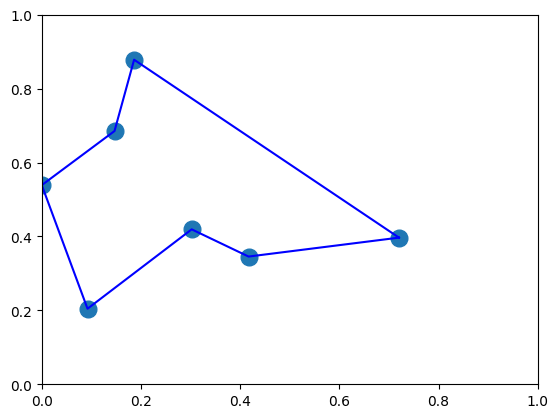

In [18]:
plt.plot(x_pos, y_pos, 'o',markersize=12)
plt.plot(x_pos[tour], y_pos[tour], 'blue')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## OMMX-OpenJij-Adapterを用いたショートカット

上記のチュートリアルでは quboへ変換 -> OpenJijで最適化 -> ommx-openjij-adapterでデコード/評価 という3つのステップを踏みましたが、実は`ommx-openjij-adapter`を用いることで、これらのステップを一気に行うことができます (現在はSimulated Annealingの場合のみ)。

In [21]:
adapter = oj_ad.OMMXOpenJijSAAdapter(instance)
sampleset = adapter.sample(instance)

このように`Adapter.sampleset`メソッドを用いることで一行で全ての流れを実行できます。また`Adapter.solve`というメソッドも提供されており、こちらではsampleで複数の回を得た後に最も良い解にフィルタリングされた結果を得ることができます。